In [ ]:
# default_exp inferno

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [ ]:
bs = 2000
data, test = get_paper_data(200000, bm=0, bs=bs, n_test=1000000)

In [ ]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [ ]:
x = torch.randn((1,10))

In [ ]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[3.0311e-02, 1.0615e-03, 1.6489e-05, 9.1019e-01, 5.6862e-08, 7.0608e-06,
          1.3968e-07, 8.3716e-16, 1.4129e-07, 5.8409e-02]]),
 tensor([[1.8934e-01, 9.6851e-02, 4.2108e-02, 3.7389e-01, 1.3548e-02, 3.5538e-02,
          1.6216e-02, 3.6769e-04, 1.6253e-02, 2.1588e-01]]),
 tensor([[0.1669, 0.1194, 0.0787, 0.2346, 0.0447, 0.0723, 0.0489, 0.0074, 0.0489,
          0.1783]]))

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [ ]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [ ]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [ ]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

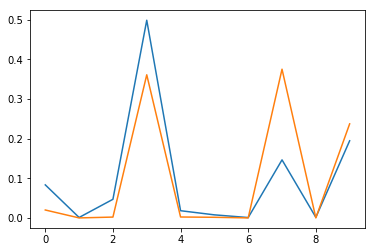

In [ ]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

In [ ]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, true_mu:float, n_alphas:int=0):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): self.alpha[0] = self.true_mu
                
    def on_batch_begin(self) -> None:
        self.wrapper.x = self.aug_data(self.wrapper.x)
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor: pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:  
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
#         print(h,ikk)
        return ikk
        
    def on_forwards_end(self) -> None:
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

In [ ]:
class PaperInferno(AbsInferno):
    def __init__(self, float_r:bool, float_l:bool, n:int=1050, true_mu:int=50):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l)
        self.float_r,self.float_l = float_r,float_l
        
    def on_train_begin(self) -> None:
        super().on_train_begin()
        if self.float_l:
            with torch.no_grad(): self.alpha[-1] = 1
        
    def aug_data(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        i = 1
        if self.float_r:
            x[:,0] += self.alpha[i]
            i += 1
        if self.float_l:
            x[:,2] *= self.alpha[i]
        return x

In [ ]:
%%time
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.Adam,lr=1e-4), loss=None,
          cbs=[PaperInferno(float_r=1, float_l=1),LossTracker(),SaveBest('weights/best_ie.h5'),EarlyStopping(5)])

1: Train=369.77502990722655 Valid=336.62190673828127
2: Train=321.4198306274414 Valid=314.8025439453125
3: Train=300.6513117980957 Valid=296.56644317626956
4: Train=286.0775180053711 Valid=281.82191955566407
5: Train=273.7230648803711 Valid=271.39975311279295
6: Train=266.17056289672854 Valid=265.68596099853517
7: Train=260.37327575683594 Valid=260.6952200317383
8: Train=256.0118412780762 Valid=257.372763671875
9: Train=252.9488055419922 Valid=255.7181167602539
10: Train=250.74052108764647 Valid=252.88789916992187
11: Train=248.67217025756835 Valid=251.4243591308594
12: Train=247.15455169677733 Valid=250.05513946533202
13: Train=245.87485397338867 Valid=248.87661804199217
14: Train=245.095682220459 Valid=246.88097534179687
15: Train=243.4746809387207 Valid=246.1181481933594
16: Train=242.76864425659178 Valid=245.39615905761718
17: Train=241.0714140319824 Valid=243.83997161865236
18: Train=240.2839598083496 Valid=242.9175897216797
19: Train=238.55288360595702 Valid=242.43698211669923
20

In [ ]:
model.save('weights/Inferno_Test_exact_bm2.h5')

model.load('weights/Inferno_Test_exact.h5')

# Results

In [ ]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [ ]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [ ]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,8,1.0
1,1,1.0
2,3,1.0
3,4,1.0
4,7,1.0


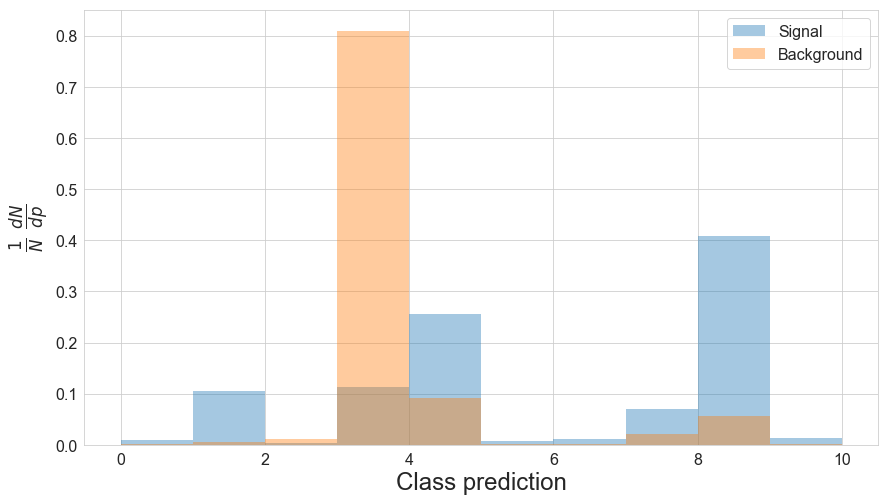

In [ ]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,8,1.0,8
1,1,1.0,1
2,3,1.0,3
3,4,1.0,4
4,7,1.0,7


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [ ]:
f_s, f_b

(tensor([1.1484e-01, 4.4400e-03, 1.1233e-01, 2.5636e-01, 7.9400e-03, 1.1886e-02,
         7.0638e-02, 4.0914e-01, 1.2422e-02, 2.0000e-13]),
 tensor([6.5280e-03, 1.1720e-02, 8.0991e-01, 9.1700e-02, 1.4180e-03, 1.1100e-03,
         2.0614e-02, 5.5748e-02, 1.2540e-03, 2.0000e-13]))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([1.2270e+01, 1.1942e+01, 8.1552e+02, 1.0452e+02, 1.8150e+00, 1.7043e+00,
         2.4146e+01, 7.6205e+01, 1.8751e+00, 2.1000e-10]), tensor(1049.9999))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([23.45174599, 23.2964592 , 23.14753532, 23.00496483, 22.86856079,
       22.73823929, 22.61390305, 22.495924  , 22.38339615, 22.27659035,
       22.17580795, 22.08018112, 21.99012375, 21.90592575, 21.82658386,
       21.75343895, 21.68410873, 21.62137222, 21.56272316, 21.50901604,
       21.4608078 , 21.4174633 , 21.37836456, 21.34458923, 21.3154335 ,
       21.29093552, 21.2710495 , 21.25516129, 21.24421883, 21.23770142,
       21.23554611, 21.2376709 , 21.24403763, 21.25520325, 21.26998138,
       21.28886032, 21.31225204, 21.33877945, 21.37020683, 21.40512276,
       21.44391251, 21.48652267, 21.53351212, 21.58372498, 21.63766861,
       21.69571495, 21.75702858, 21.82196808, 21.89086723, 21.9633503 ,
       22.03889084, 22.11834335, 22.20172119, 22.28753853, 22.37724304,
       22.47019196, 22.56606865, 22.66562271, 22.76839256, 22.87441826,
       22.98370552])

In [ ]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [ ]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

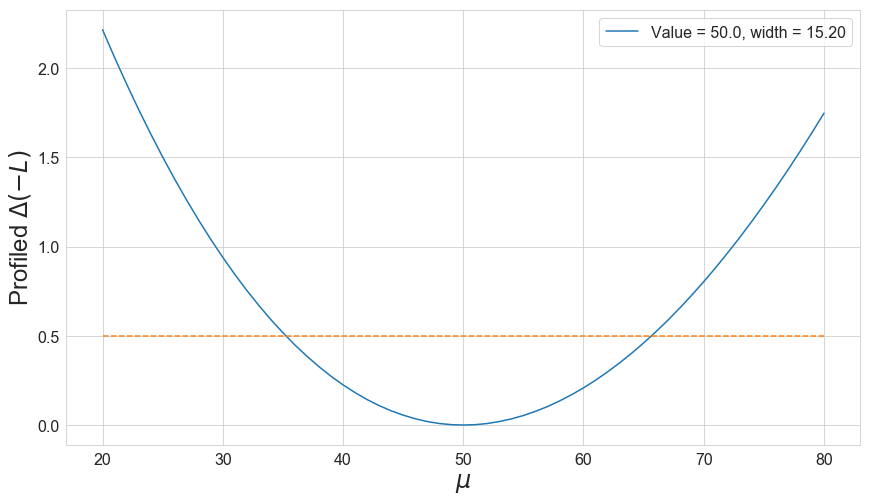

In [ ]:
plot_likelihood(y-y.min())

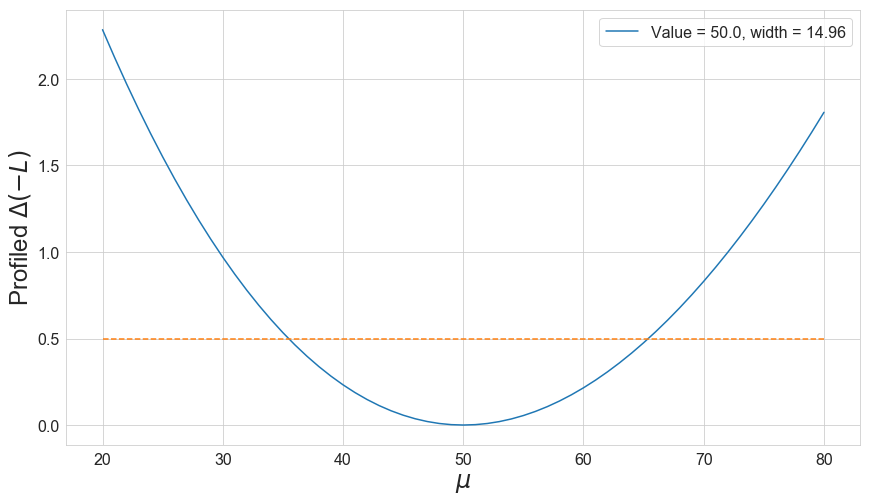

In [ ]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,8,1.0,8,8,8,8,8,8,8,8,8,8,8
1,1,1.0,1,1,1,1,1,1,1,1,1,1,1
2,3,1.0,3,3,3,3,3,3,3,3,3,3,3
3,4,1.0,4,4,4,4,4,4,4,4,4,4,4
4,7,1.0,7,7,7,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999996,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999997,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999998,3,0.0,3,3,3,3,3,3,3,3,3,3,3


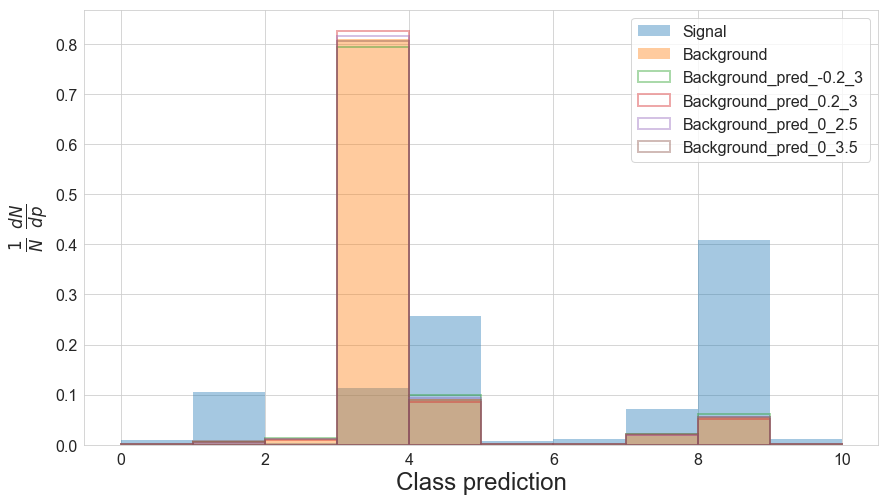

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([4.7080e-03, 1.4148e-02, 7.9776e-01, 1.0041e-01, 8.3200e-04, 7.3000e-04,
        2.0950e-02, 5.9424e-02, 1.0380e-03, 2.0000e-13])
tensor([7.2540e-03, 1.4260e-02, 7.9310e-01, 9.8654e-02, 1.4040e-03, 1.1900e-03,
        2.2044e-02, 6.0694e-02, 1.4040e-03, 2.0000e-13])
tensor([1.0448e-02, 1.4386e-02, 7.8836e-01, 9.7082e-02, 2.0980e-03, 1.6900e-03,
        2.2778e-02, 6.1364e-02, 1.7960e-03, 2.0000e-13])
tensor([3.9820e-03, 1.1608e-02, 8.1457e-01, 9.3458e-02, 8.4600e-04, 6.5000e-04,
        1.9520e-02, 5.4478e-02, 8.8800e-04, 2.0000e-13])
tensor([6.5280e-03, 1.1720e-02, 8.0991e-01, 9.1700e-02, 1.4180e-03, 1.1100e-03,
        2.0614e-02, 5.5748e-02, 1.2540e-03, 2.0000e-13])
tensor([9.7220e-03, 1.1846e-02, 8.0517e-01, 9.0128e-02, 2.1120e-03, 1.6100e-03,
        2.1348e-02, 5.6418e-02, 1.6460e-03, 2.0000e-13])
tensor([3.3300e-03, 9.4280e-03, 8.3094e-01, 8.6602e-02, 8.1800e-04, 5.3000e-04,
        1.8164e-02, 4.9474e-02, 7.1400e-04, 2.0000e-13])
tensor([5.8760e-03, 9.5400e-03, 8.2628e-0

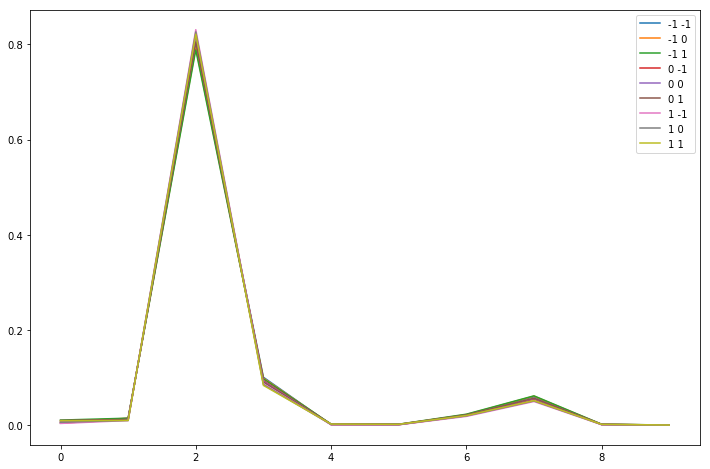

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [ ]:
nll = to_np(nll)

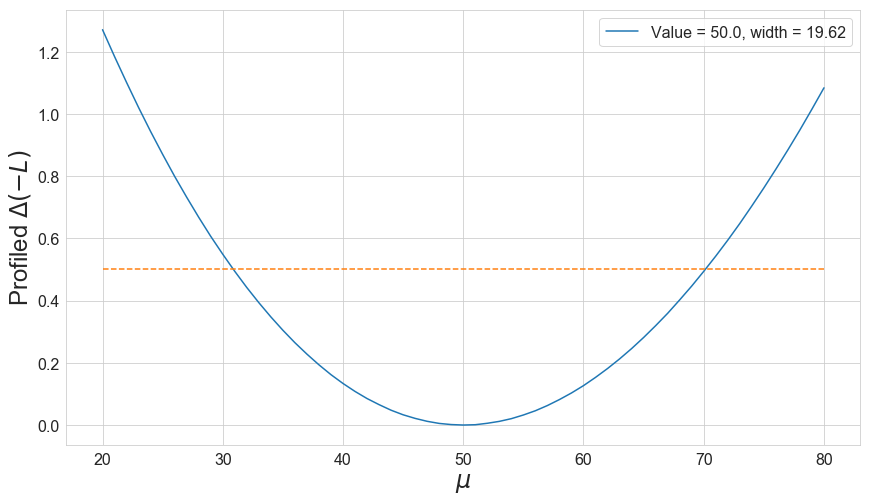

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [ ]:
nll = to_np(nll)

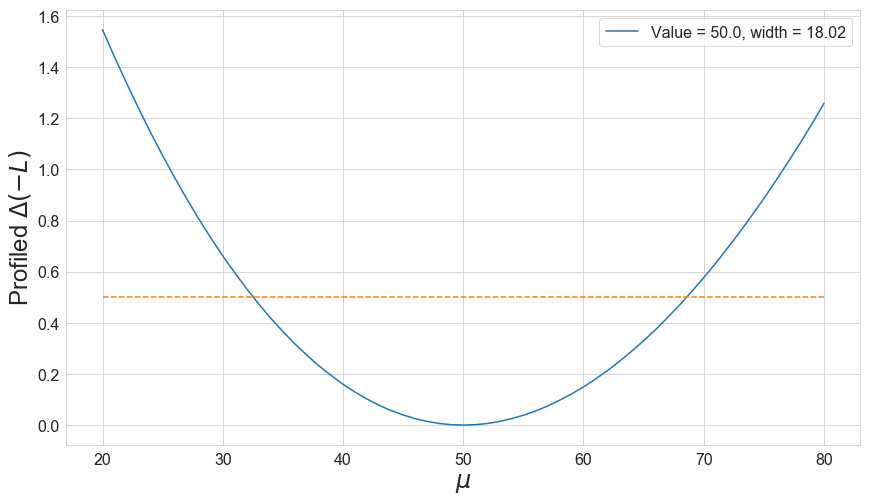

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [ ]:
nll = to_np(nll)

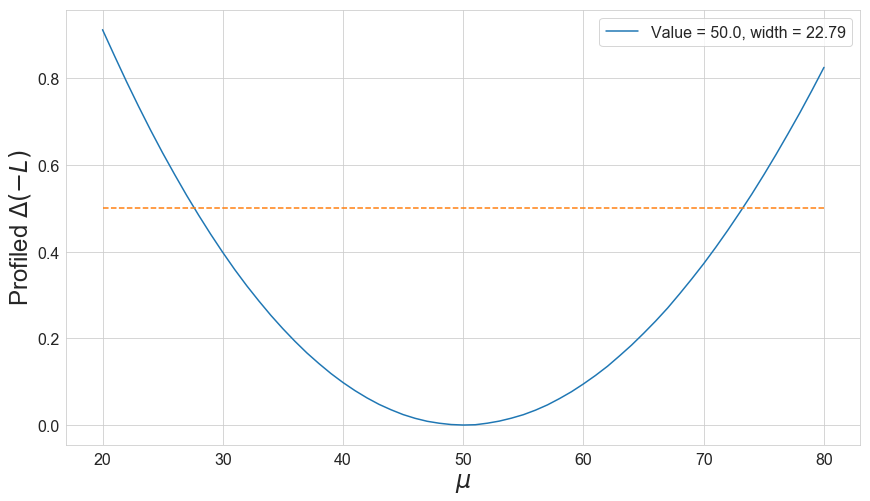

In [ ]:
plot_likelihood(nll-nll.min())